# Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Reshape
from tensorflow.keras.optimizers import Adam


## Load Data

In [2]:
def load_images(folder_path, num_images=500, image_size=(32, 32)):
    data = []
    labels = []

    label = os.path.basename(folder_path)  # Extract the label from the folder name

    count = 0  # Counter to keep track of the number of loaded images

    for filename in os.listdir(folder_path):
        if count >= num_images:
            break  # Stop loading images once the desired number is reached

        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, image_size)  # Resize images to a common size
        data.append(img)
        labels.append(label)

        count += 1

    return np.array(data), np.array(labels)

# Replace 'simple CNN Code' with the actual path to your dataset folder
dataset_path = "C:\\Users\\ASUS\\Brain Tumor Classification"

# Load 400 images for each type of brain tumor
num_images_per_class = 400
data_glioma, labels_glioma = load_images(os.path.join(dataset_path, 'glioma_tumor'), num_images=num_images_per_class)
data_meningioma, labels_meningioma = load_images(os.path.join(dataset_path, 'meningioma_tumor'), num_images=num_images_per_class)
data_pituitary, labels_pituitary = load_images(os.path.join(dataset_path, 'pituitary_tumor'), num_images=num_images_per_class)

## Concatenate Data

In [3]:
# Combine data and labels for all tumor types
All_data = np.concatenate([data_glioma, data_pituitary, data_meningioma])
All_labels = np.concatenate([labels_glioma, labels_meningioma, labels_pituitary])

## Plot Distrubution of Data

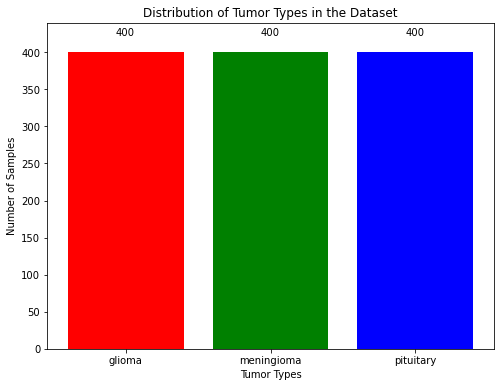

In [4]:
unique_labels, label_counts = np.unique(All_labels, return_counts=True)
plt.figure(figsize=(8, 6))

# Adjust ylim to create space between the outline and data level
plt.bar(unique_labels, label_counts, color=['red', 'green', 'blue'])
plt.xlabel('Tumor Types')
plt.ylabel('Number of Samples')
plt.title('Distribution of Tumor Types in the Dataset')

max_count = max(label_counts)  # Find the maximum count

# Adjust ylim to create space between the outline and data level
plt.ylim(0, max_count + 0.1 * max_count)

for i, count in enumerate(label_counts):
    plt.text(i, count + 0.05 * max_count, str(count), ha='center', va='bottom' if count > 0.9 * max_count else 'top')

plt.xticks(unique_labels, ['glioma', 'meningioma', 'pituitary'])
plt.show()

## Normalize & Split 

In [5]:
# Normalize Pixel Values
All_data_normalized = All_data / 255.0
# Encode Labels
label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(All_labels)
train_data, test_data, train_labels, test_labels = train_test_split(
    All_data_normalized, all_labels_encoded, test_size=0.20, random_state=42
)

### Check Train data shape

In [6]:
train_data.shape

(960, 32, 32, 3)

### Check test Data Shape

In [7]:
test_data.shape

(240, 32, 32, 3)

# CNN as Feature extractor

***Initially, a Sequential model is built with three layers: a Conv2D layer with 64 filters of size 3x3 and ReLU activation, which processes input images of shape 32x32x3 to detect low-level features; a MaxPooling2D layer with a 2x2 pooling window that reduces the spatial dimensions of the feature maps by half, thus retaining the most important features; and a Flatten layer that converts the 2D feature maps into a 1D vector. To adapt this model for feature extraction, the final model definition uses the Model class to specify the original input and the output of the MaxPooling2D layer, effectively removing the Flatten layer. This adjustment enables the model to output 2D feature maps instead of a 1D vector, making it suitable for further processing or integration into other models for various tasks such as image classification or object detection.***

In [8]:
from tensorflow.keras import layers, models

cnn_model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
#      layers.Conv2D(32, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
    layers.Flatten()
])

# Remove the classification head (fully connected layers) for feature extraction
cnn_model = models.Model(inputs=cnn_model.inputs, outputs=cnn_model.layers[-2].output)

In [9]:
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 64)        0         
 D)                                                              
                                                                 
Total params: 1792 (7.00 KB)
Trainable params: 1792 (7.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


***(cnn_model.predict):
This part takes input data and passes it through the model to get the output. In the context of a CNN designed for feature extraction, this output will be the feature maps generated by the model.***

In [9]:
train_features = cnn_model.predict(train_data)
test_features = cnn_model.predict(test_data)

8/8 [==============================] - 0s 6ms/step


***np.reshape: This function from the NumPy library reshapes an array without changing its data. The goal is to transform the multidimensional feature maps into a 2D array where each row represents the features of a single image.***

In [1]:
# Flatten the features
train_features_flattened = np.reshape(train_features, (train_features.shape[0], -1))
test_features_flattened = np.reshape(test_features, (test_features.shape[0], -1))

NameError: name 'np' is not defined

## SVM

In [58]:
from sklearn.svm import SVC

# Create SVM model
svm_model = SVC(kernel='linear', random_state=42)

# Train SVM model
svm_model.fit(train_features_flattened, train_labels)

SVC(kernel='linear', random_state=42)

In [59]:
from sklearn.metrics import accuracy_score, classification_report

# Flatten the test features
test_features_flattened = np.reshape(test_features, (test_features.shape[0], -1))

# Make predictions
predictions = svm_model.predict(test_features_flattened)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate classification report
report = classification_report(test_labels, predictions, target_names=label_encoder.classes_)
print('Classification Report:\n', report)

Accuracy: 94.58%
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.93      0.96        87
meningioma_tumor       0.95      0.96      0.95        73
 pituitary_tumor       0.90      0.95      0.93        80

        accuracy                           0.95       240
       macro avg       0.95      0.95      0.95       240
    weighted avg       0.95      0.95      0.95       240



In [60]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    print(f'Kernel: {kernel}')

    c_value = 0.1

    while c_value <= 50.0:
        svm_model = SVC(C=c_value, kernel=kernel, random_state=42)
        svm_model.fit(train_features_flattened, train_labels)
        predictions = svm_model.predict(test_features_flattened)
        accuracy = accuracy_score(test_labels, predictions)

        print(f'C: {c_value:.2f}, Accuracy: {accuracy * 100:.2f}')

        report = classification_report(test_labels, predictions, target_names=label_encoder.classes_)
        print('Classification Report:\n', report)
        c_value += 0.5

    print('-' * 50)

Kernel: linear
C: 0.10, Accuracy: 91.67
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.92      0.94      0.93        87
meningioma_tumor       0.92      0.97      0.95        73
 pituitary_tumor       0.91      0.84      0.87        80

        accuracy                           0.92       240
       macro avg       0.92      0.92      0.92       240
    weighted avg       0.92      0.92      0.92       240

C: 0.60, Accuracy: 94.17
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.98      0.93      0.95        87
meningioma_tumor       0.95      0.96      0.95        73
 pituitary_tumor       0.90      0.94      0.92        80

        accuracy                           0.94       240
       macro avg       0.94      0.94      0.94       240
    weighted avg       0.94      0.94      0.94       240

C: 1.10, Accuracy: 95.00
Classification Report:
                   pr

C: 9.10, Accuracy: 97.08
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.95      0.97        87
meningioma_tumor       0.99      0.99      0.99        73
 pituitary_tumor       0.94      0.97      0.96        80

        accuracy                           0.97       240
       macro avg       0.97      0.97      0.97       240
    weighted avg       0.97      0.97      0.97       240

C: 9.60, Accuracy: 97.08
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.95      0.97        87
meningioma_tumor       0.99      0.99      0.99        73
 pituitary_tumor       0.94      0.97      0.96        80

        accuracy                           0.97       240
       macro avg       0.97      0.97      0.97       240
    weighted avg       0.97      0.97      0.97       240

C: 10.10, Accuracy: 97.08
Classification Report:
                   precision    rec

C: 18.10, Accuracy: 96.67
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.98      0.94      0.96        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.94      0.96      0.95        80

        accuracy                           0.97       240
       macro avg       0.97      0.97      0.97       240
    weighted avg       0.97      0.97      0.97       240

C: 18.60, Accuracy: 96.67
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.98      0.94      0.96        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.94      0.96      0.95        80

        accuracy                           0.97       240
       macro avg       0.97      0.97      0.97       240
    weighted avg       0.97      0.97      0.97       240

C: 19.10, Accuracy: 96.67
Classification Report:
                   precision    r

C: 27.10, Accuracy: 97.08
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.98      0.95      0.97        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.95      0.96      0.96        80

        accuracy                           0.97       240
       macro avg       0.97      0.97      0.97       240
    weighted avg       0.97      0.97      0.97       240

C: 27.60, Accuracy: 97.08
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.98      0.95      0.97        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.95      0.96      0.96        80

        accuracy                           0.97       240
       macro avg       0.97      0.97      0.97       240
    weighted avg       0.97      0.97      0.97       240

C: 28.10, Accuracy: 97.08
Classification Report:
                   precision    r

C: 36.10, Accuracy: 97.08
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.98      0.95      0.97        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.95      0.96      0.96        80

        accuracy                           0.97       240
       macro avg       0.97      0.97      0.97       240
    weighted avg       0.97      0.97      0.97       240

C: 36.60, Accuracy: 97.08
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.98      0.95      0.97        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.95      0.96      0.96        80

        accuracy                           0.97       240
       macro avg       0.97      0.97      0.97       240
    weighted avg       0.97      0.97      0.97       240

C: 37.10, Accuracy: 97.08
Classification Report:
                   precision    r

C: 45.10, Accuracy: 97.08
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.98      0.95      0.97        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.95      0.96      0.96        80

        accuracy                           0.97       240
       macro avg       0.97      0.97      0.97       240
    weighted avg       0.97      0.97      0.97       240

C: 45.60, Accuracy: 97.08
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.98      0.95      0.97        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.95      0.96      0.96        80

        accuracy                           0.97       240
       macro avg       0.97      0.97      0.97       240
    weighted avg       0.97      0.97      0.97       240

C: 46.10, Accuracy: 97.08
Classification Report:
                   precision    r

C: 4.10, Accuracy: 94.58
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.96      0.93      0.95        87
meningioma_tumor       0.97      0.96      0.97        73
 pituitary_tumor       0.90      0.95      0.93        80

        accuracy                           0.95       240
       macro avg       0.95      0.95      0.95       240
    weighted avg       0.95      0.95      0.95       240

C: 4.60, Accuracy: 95.00
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.98      0.93      0.95        87
meningioma_tumor       0.97      0.96      0.97        73
 pituitary_tumor       0.91      0.96      0.93        80

        accuracy                           0.95       240
       macro avg       0.95      0.95      0.95       240
    weighted avg       0.95      0.95      0.95       240

C: 5.10, Accuracy: 95.00
Classification Report:
                   precision    reca

C: 13.10, Accuracy: 96.25
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.98      0.94      0.96        87
meningioma_tumor       0.99      0.99      0.99        73
 pituitary_tumor       0.93      0.96      0.94        80

        accuracy                           0.96       240
       macro avg       0.96      0.96      0.96       240
    weighted avg       0.96      0.96      0.96       240

C: 13.60, Accuracy: 96.67
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.98      0.95      0.97        87
meningioma_tumor       0.99      0.99      0.99        73
 pituitary_tumor       0.94      0.96      0.95        80

        accuracy                           0.97       240
       macro avg       0.97      0.97      0.97       240
    weighted avg       0.97      0.97      0.97       240

C: 14.10, Accuracy: 96.67
Classification Report:
                   precision    r

C: 22.10, Accuracy: 97.08
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.94      0.96        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.94      0.97      0.96        80

        accuracy                           0.97       240
       macro avg       0.97      0.97      0.97       240
    weighted avg       0.97      0.97      0.97       240

C: 22.60, Accuracy: 97.08
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.94      0.96        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.94      0.97      0.96        80

        accuracy                           0.97       240
       macro avg       0.97      0.97      0.97       240
    weighted avg       0.97      0.97      0.97       240

C: 23.10, Accuracy: 97.08
Classification Report:
                   precision    r

C: 31.10, Accuracy: 97.50
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.95      0.97        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.95      0.97      0.96        80

        accuracy                           0.97       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.98      0.97      0.97       240

C: 31.60, Accuracy: 97.50
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.95      0.97        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.95      0.97      0.96        80

        accuracy                           0.97       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.98      0.97      0.97       240

C: 32.10, Accuracy: 97.50
Classification Report:
                   precision    r

C: 40.10, Accuracy: 97.50
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.95      0.97        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.95      0.97      0.96        80

        accuracy                           0.97       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.98      0.97      0.97       240

C: 40.60, Accuracy: 97.50
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.95      0.97        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.95      0.97      0.96        80

        accuracy                           0.97       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.98      0.97      0.97       240

C: 41.10, Accuracy: 97.50
Classification Report:
                   precision    r

C: 49.10, Accuracy: 97.92
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.97      0.98        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.96      0.97      0.97        80

        accuracy                           0.98       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.98      0.98      0.98       240

C: 49.60, Accuracy: 97.92
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.97      0.98        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.96      0.97      0.97        80

        accuracy                           0.98       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.98      0.98      0.98       240

--------------------------------------------------
Kernel: rbf
C: 0.10, Accuracy: 

C: 8.10, Accuracy: 95.42
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.93      0.96        87
meningioma_tumor       0.96      0.97      0.97        73
 pituitary_tumor       0.92      0.96      0.94        80

        accuracy                           0.95       240
       macro avg       0.95      0.96      0.95       240
    weighted avg       0.96      0.95      0.95       240

C: 8.60, Accuracy: 95.83
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.93      0.96        87
meningioma_tumor       0.97      0.97      0.97        73
 pituitary_tumor       0.92      0.97      0.95        80

        accuracy                           0.96       240
       macro avg       0.96      0.96      0.96       240
    weighted avg       0.96      0.96      0.96       240

C: 9.10, Accuracy: 95.83
Classification Report:
                   precision    reca

C: 17.10, Accuracy: 96.25
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.94      0.96        87
meningioma_tumor       0.99      0.97      0.98        73
 pituitary_tumor       0.92      0.97      0.95        80

        accuracy                           0.96       240
       macro avg       0.96      0.96      0.96       240
    weighted avg       0.96      0.96      0.96       240

C: 17.60, Accuracy: 96.25
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.94      0.96        87
meningioma_tumor       0.99      0.97      0.98        73
 pituitary_tumor       0.92      0.97      0.95        80

        accuracy                           0.96       240
       macro avg       0.96      0.96      0.96       240
    weighted avg       0.96      0.96      0.96       240

C: 18.10, Accuracy: 96.67
Classification Report:
                   precision    r

C: 26.10, Accuracy: 97.08
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.94      0.96        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.94      0.97      0.96        80

        accuracy                           0.97       240
       macro avg       0.97      0.97      0.97       240
    weighted avg       0.97      0.97      0.97       240

C: 26.60, Accuracy: 97.08
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.94      0.96        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.94      0.97      0.96        80

        accuracy                           0.97       240
       macro avg       0.97      0.97      0.97       240
    weighted avg       0.97      0.97      0.97       240

C: 27.10, Accuracy: 97.50
Classification Report:
                   precision    r

C: 35.10, Accuracy: 97.92
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.97      0.98        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.96      0.97      0.97        80

        accuracy                           0.98       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.98      0.98      0.98       240

C: 35.60, Accuracy: 97.92
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.97      0.98        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.96      0.97      0.97        80

        accuracy                           0.98       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.98      0.98      0.98       240

C: 36.10, Accuracy: 97.92
Classification Report:
                   precision    r

C: 44.10, Accuracy: 97.92
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.97      0.98        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.96      0.97      0.97        80

        accuracy                           0.98       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.98      0.98      0.98       240

C: 44.60, Accuracy: 97.92
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.97      0.98        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.96      0.97      0.97        80

        accuracy                           0.98       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.98      0.98      0.98       240

C: 45.10, Accuracy: 97.92
Classification Report:
                   precision    r

C: 3.10, Accuracy: 45.83
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.38      0.57      0.46        87
meningioma_tumor       0.57      0.63      0.60        73
 pituitary_tumor       0.52      0.17      0.26        80

        accuracy                           0.46       240
       macro avg       0.49      0.46      0.44       240
    weighted avg       0.48      0.46      0.43       240

C: 3.60, Accuracy: 45.00
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.38      0.57      0.46        87
meningioma_tumor       0.55      0.62      0.58        73
 pituitary_tumor       0.48      0.16      0.24        80

        accuracy                           0.45       240
       macro avg       0.47      0.45      0.43       240
    weighted avg       0.47      0.45      0.42       240

C: 4.10, Accuracy: 45.00
Classification Report:
                   precision    reca

C: 12.10, Accuracy: 43.75
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.38      0.57      0.45        87
meningioma_tumor       0.53      0.62      0.57        73
 pituitary_tumor       0.45      0.12      0.20        80

        accuracy                           0.44       240
       macro avg       0.45      0.44      0.41       240
    weighted avg       0.45      0.44      0.40       240

C: 12.60, Accuracy: 43.75
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.38      0.57      0.45        87
meningioma_tumor       0.53      0.62      0.57        73
 pituitary_tumor       0.45      0.12      0.20        80

        accuracy                           0.44       240
       macro avg       0.45      0.44      0.41       240
    weighted avg       0.45      0.44      0.40       240

C: 13.10, Accuracy: 44.17
Classification Report:
                   precision    r

C: 21.10, Accuracy: 44.17
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.38      0.57      0.45        87
meningioma_tumor       0.53      0.62      0.57        73
 pituitary_tumor       0.50      0.14      0.22        80

        accuracy                           0.44       240
       macro avg       0.47      0.44      0.41       240
    weighted avg       0.46      0.44      0.41       240

C: 21.60, Accuracy: 44.17
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.38      0.57      0.45        87
meningioma_tumor       0.53      0.62      0.57        73
 pituitary_tumor       0.50      0.14      0.22        80

        accuracy                           0.44       240
       macro avg       0.47      0.44      0.41       240
    weighted avg       0.46      0.44      0.41       240

C: 22.10, Accuracy: 44.17
Classification Report:
                   precision    r

C: 30.10, Accuracy: 44.58
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.38      0.59      0.46        87
meningioma_tumor       0.53      0.62      0.57        73
 pituitary_tumor       0.52      0.14      0.22        80

        accuracy                           0.45       240
       macro avg       0.48      0.45      0.42       240
    weighted avg       0.47      0.45      0.41       240

C: 30.60, Accuracy: 44.58
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.38      0.59      0.46        87
meningioma_tumor       0.53      0.62      0.57        73
 pituitary_tumor       0.52      0.14      0.22        80

        accuracy                           0.45       240
       macro avg       0.48      0.45      0.42       240
    weighted avg       0.47      0.45      0.41       240

C: 31.10, Accuracy: 44.58
Classification Report:
                   precision    r

C: 39.10, Accuracy: 44.17
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.38      0.57      0.45        87
meningioma_tumor       0.53      0.62      0.57        73
 pituitary_tumor       0.50      0.14      0.22        80

        accuracy                           0.44       240
       macro avg       0.47      0.44      0.41       240
    weighted avg       0.46      0.44      0.41       240

C: 39.60, Accuracy: 44.17
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.38      0.57      0.45        87
meningioma_tumor       0.53      0.62      0.57        73
 pituitary_tumor       0.50      0.14      0.22        80

        accuracy                           0.44       240
       macro avg       0.47      0.44      0.41       240
    weighted avg       0.46      0.44      0.41       240

C: 40.10, Accuracy: 44.17
Classification Report:
                   precision    r

C: 48.10, Accuracy: 43.75
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.37      0.57      0.45        87
meningioma_tumor       0.52      0.60      0.56        73
 pituitary_tumor       0.50      0.14      0.22        80

        accuracy                           0.44       240
       macro avg       0.47      0.44      0.41       240
    weighted avg       0.46      0.44      0.41       240

C: 48.60, Accuracy: 43.75
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.37      0.57      0.45        87
meningioma_tumor       0.52      0.60      0.56        73
 pituitary_tumor       0.50      0.14      0.22        80

        accuracy                           0.44       240
       macro avg       0.47      0.44      0.41       240
    weighted avg       0.46      0.44      0.41       240

C: 49.10, Accuracy: 43.75
Classification Report:
                   precision    r

### Best Result
### Kernel: Poly
### C: 34.60
### Accuracy: 97.92

Among All types of Kernel Poly gives the best result, So we now further investigate with Poly Kernel.

## Poly Kernel

In [61]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import numpy as np


for degree in [2, 3, 4]:
    print(f'Degree: {degree}')

    for c_value in np.arange(25, 71, 2):
        svm_model = SVC(C=c_value, kernel='poly', degree=degree, random_state=42)
        svm_model.fit(train_features_flattened, train_labels)

        predictions = svm_model.predict(test_features_flattened)
        accuracy = accuracy_score(test_labels, predictions)
        print(f'C: {c_value:.2f}, Accuracy: {accuracy * 100:.2f}')
        report = classification_report(test_labels, predictions, target_names=label_encoder.classes_)
        print('Classification Report:\n', report)

    print('-' * 50)

Degree: 2
C: 25.00, Accuracy: 96.67
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.95      0.97        87
meningioma_tumor       0.99      0.97      0.98        73
 pituitary_tumor       0.93      0.97      0.95        80

        accuracy                           0.97       240
       macro avg       0.97      0.97      0.97       240
    weighted avg       0.97      0.97      0.97       240

C: 27.00, Accuracy: 96.67
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.95      0.97        87
meningioma_tumor       0.99      0.97      0.98        73
 pituitary_tumor       0.93      0.97      0.95        80

        accuracy                           0.97       240
       macro avg       0.97      0.97      0.97       240
    weighted avg       0.97      0.97      0.97       240

C: 29.00, Accuracy: 96.67
Classification Report:
                   prec

C: 61.00, Accuracy: 97.92
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.97      0.98        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.96      0.97      0.97        80

        accuracy                           0.98       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.98      0.98      0.98       240

C: 63.00, Accuracy: 97.50
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.95      0.97        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.95      0.97      0.96        80

        accuracy                           0.97       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.98      0.97      0.97       240

C: 65.00, Accuracy: 97.50
Classification Report:
                   precision    r

C: 51.00, Accuracy: 97.92
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.97      0.98        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.96      0.97      0.97        80

        accuracy                           0.98       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.98      0.98      0.98       240

C: 53.00, Accuracy: 97.92
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.97      0.98        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.96      0.97      0.97        80

        accuracy                           0.98       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.98      0.98      0.98       240

C: 55.00, Accuracy: 97.92
Classification Report:
                   precision    r

C: 41.00, Accuracy: 97.50
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.98      0.97      0.97        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.96      0.96      0.96        80

        accuracy                           0.97       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.97      0.97      0.97       240

C: 43.00, Accuracy: 97.50
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.98      0.97      0.97        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.96      0.96      0.96        80

        accuracy                           0.97       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.97      0.97      0.97       240

C: 45.00, Accuracy: 97.50
Classification Report:
                   precision    r

# Investigation With Poly

In [62]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

test_features_flattened = np.reshape(test_features, (test_features.shape[0], -1))

for degree in [3, 4]:
    print(f'Degree: {degree}')
    for c_value in np.arange(35, 150, 2):
        svm_model = SVC(C=c_value, kernel='poly', degree=degree, random_state=42)
        svm_model.fit(train_features_flattened, train_labels)
        
        predictions = svm_model.predict(test_features_flattened)
        
        accuracy = accuracy_score(test_labels, predictions)
        print(f'C: {c_value:.2f}, Accuracy: {accuracy * 100:.2f}')
        report = classification_report(test_labels, predictions, target_names=label_encoder.classes_)
        print('Classification Report:\n', report)

    print('-' * 50)

Degree: 3
C: 35.00, Accuracy: 97.50
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.95      0.97        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.95      0.97      0.96        80

        accuracy                           0.97       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.98      0.97      0.97       240

C: 37.00, Accuracy: 97.50
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.95      0.97        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.95      0.97      0.96        80

        accuracy                           0.97       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.98      0.97      0.97       240

C: 39.00, Accuracy: 97.50
Classification Report:
                   prec

C: 71.00, Accuracy: 97.92
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.97      0.98        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.96      0.97      0.97        80

        accuracy                           0.98       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.98      0.98      0.98       240

C: 73.00, Accuracy: 97.92
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.97      0.98        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.96      0.97      0.97        80

        accuracy                           0.98       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.98      0.98      0.98       240

C: 75.00, Accuracy: 97.92
Classification Report:
                   precision    r

C: 107.00, Accuracy: 97.92
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.97      0.98        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.96      0.97      0.97        80

        accuracy                           0.98       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.98      0.98      0.98       240

C: 109.00, Accuracy: 97.92
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.97      0.98        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.96      0.97      0.97        80

        accuracy                           0.98       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.98      0.98      0.98       240

C: 111.00, Accuracy: 97.92
Classification Report:
                   precision  

C: 143.00, Accuracy: 97.92
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.97      0.98        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.96      0.97      0.97        80

        accuracy                           0.98       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.98      0.98      0.98       240

C: 145.00, Accuracy: 97.92
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.97      0.98        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.96      0.97      0.97        80

        accuracy                           0.98       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.98      0.98      0.98       240

C: 147.00, Accuracy: 97.92
Classification Report:
                   precision  

C: 63.00, Accuracy: 97.50
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.98      0.97      0.97        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.96      0.96      0.96        80

        accuracy                           0.97       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.97      0.97      0.97       240

C: 65.00, Accuracy: 97.50
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.98      0.97      0.97        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.96      0.96      0.96        80

        accuracy                           0.97       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.97      0.97      0.97       240

C: 67.00, Accuracy: 97.50
Classification Report:
                   precision    r

C: 99.00, Accuracy: 97.50
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.98      0.97      0.97        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.96      0.96      0.96        80

        accuracy                           0.97       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.97      0.97      0.97       240

C: 101.00, Accuracy: 97.50
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.98      0.97      0.97        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.96      0.96      0.96        80

        accuracy                           0.97       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.97      0.97      0.97       240

C: 103.00, Accuracy: 97.50
Classification Report:
                   precision   

C: 135.00, Accuracy: 98.33
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.98      0.98        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.97      0.97      0.97        80

        accuracy                           0.98       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.98      0.98      0.98       240

C: 137.00, Accuracy: 98.33
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.98      0.98        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.97      0.97      0.97        80

        accuracy                           0.98       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.98      0.98      0.98       240

C: 139.00, Accuracy: 98.33
Classification Report:
                   precision  

## Kernel: Poly
## Degree: 4
## C: 149.00
## Accuracy: 98.75

Among our investigation, the best result is achieved with a Poly kernel, a degree of 4, and a C value of 149, yielding an accuracy of 98.33%.

### RBF

In [ ]:
pip install joblib

## Hyper parameter Tune of SVM

In [63]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid_svc = {'C': [0.1, 1, 10, 100],
                  'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                  'gamma': ['scale', 'auto', 0.1, 1, 10]}

svc_model = SVC()

grid_search_svc = GridSearchCV(svc_model, param_grid_svc, cv=5)
grid_search_svc.fit(train_features_flattened, train_labels)

best_params_svc = grid_search_svc.best_params_
best_svc_model = grid_search_svc.best_estimator_

print("Best Parameters for Support Vector Classifier:", best_params_svc)

predictions_svc = best_svc_model.predict(test_features_flattened)

Best Parameters for Support Vector Classifier: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


In [64]:

accuracy = accuracy_score(test_labels, predictions_svc)
print(f'Accuracy: {accuracy * 100:.2f}%')

report = classification_report(test_labels, predictions_svc, target_names=label_encoder.classes_)
print('Classification Report:\n', report)

Accuracy: 97.92%
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.97      0.98        87
meningioma_tumor       0.99      1.00      0.99        73
 pituitary_tumor       0.96      0.97      0.97        80

        accuracy                           0.98       240
       macro avg       0.98      0.98      0.98       240
    weighted avg       0.98      0.98      0.98       240



# Best Model Run Based On Our Analysis

In [13]:
from sklearn.svm import SVC

# Flatten the features
train_features_flattened = np.reshape(train_features, (train_features.shape[0], -1))
test_features_flattened = np.reshape(test_features, (test_features.shape[0], -1))

# Create SVM model
svm_model = SVC(kernel='poly', degree=4, C=149, random_state=42)

# Train SVM model
svm_model.fit(train_features_flattened, train_labels)

SVC(C=149, degree=4, kernel='poly', random_state=42)

In [14]:
test_features_flattened = np.reshape(test_features, (test_features.shape[0], -1))
predictions = svm_model.predict(test_features_flattened)

accuracy = accuracy_score(test_labels, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

report = classification_report(test_labels, predictions, target_names=label_encoder.classes_)
print('Classification Report:\n', report)

Accuracy: 98.75%
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.99      0.98      0.98        87
meningioma_tumor       1.00      1.00      1.00        73
 pituitary_tumor       0.98      0.99      0.98        80

        accuracy                           0.99       240
       macro avg       0.99      0.99      0.99       240
    weighted avg       0.99      0.99      0.99       240



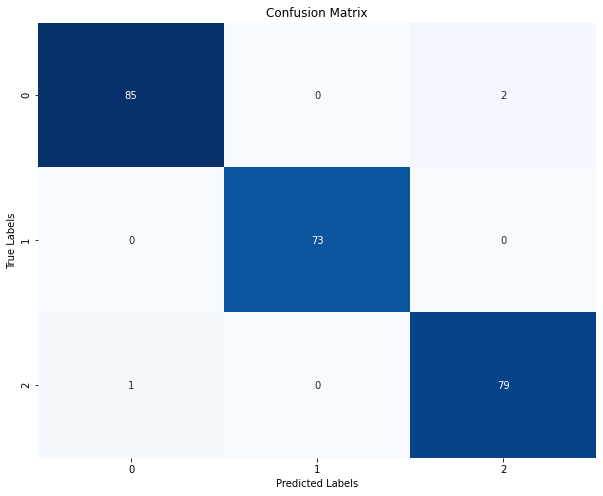

In [17]:
conf_matrix = confusion_matrix(test_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()